***Word Vectors Overview using Gensim Library*** 

In [2]:
import gensim.downloader as api

wv = api.load("word2vec-google-news-300")

In [3]:
wv.similarity(w1="great", w2="good")

0.72915095

In [4]:
wv_great = wv["great"]
wv_good = wv["good"]

In [5]:
wv_great.shape, wv_good.shape

((300,), (300,))

In [6]:
import pandas as pd

df = pd.read_csv("C:/Users/user/Desktop/fake_or_real_news.csv")

In [7]:
df.head(5)

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [8]:
df.shape

(6335, 2)

In [10]:
df.label.value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

In [11]:
df["label_num"] = df.label.map({
    "FAKE" : 0, 
    "REAL" : 1
})

In [12]:
import spacy
nlp = spacy.load("en_core_web_lg") # if this fails then run "python -m spacy download en_core_web_lg" to download that model

def preprocess_and_vectorize(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
        
    return wv.get_mean_vector(filtered_tokens)

In [15]:
v = preprocess_and_vectorize("Don't worry if you don't understand")
v.shape

(300,)

In [19]:
wv.get_mean_vector(["worry", "understand"])

array([ 0.00235079, -0.00284596, -0.03638233,  0.00413919, -0.10635224,
        0.05758579,  0.13348952, -0.00689176,  0.05995331, -0.02875906,
       -0.02279907, -0.06939262, -0.01549996,  0.03538099, -0.0873947 ,
        0.10044542,  0.02490648,  0.11501945,  0.00442711, -0.07228819,
       -0.04447255,  0.02785169,  0.03338735,  0.02222995,  0.07053161,
        0.06723307,  0.03483712, -0.0873695 ,  0.04152397, -0.0969665 ,
       -0.00914938,  0.00555944, -0.0277799 , -0.00701522,  0.05281431,
       -0.01066206,  0.02466576,  0.02378148,  0.0279402 ,  0.05527755,
        0.01359304, -0.01062085,  0.06734448, -0.03492254, -0.08421434,
       -0.04324378, -0.03578918, -0.00817786, -0.02093195,  0.01856531,
       -0.07064191,  0.05023994, -0.03036207, -0.0412168 , -0.00684169,
        0.05189689, -0.04097777, -0.05789134,  0.044417  , -0.0470418 ,
       -0.01475445,  0.01373999, -0.00459672,  0.00419459,  0.04307397,
       -0.01500929, -0.08037488,  0.05358911, -0.0211829 , -0.00

In [20]:
wv.get_mean_vector(["worry", "understand"])[:3]

array([ 0.00235079, -0.00284596, -0.03638233], dtype=float32)

In [16]:
df['vector'] = df['text'].apply(lambda text: preprocess_and_vectorize(text))

In [17]:
df.head(5)

,text,label,label_num,vector
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,"[0.024779696, 0.012828968, -0.00094372977, 0.0..."
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0,"[0.027095925, 0.010018359, -0.003129262, 0.026..."
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,1,"[0.007654696, 0.017431496, 0.01465004, 0.02029..."
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0,"[0.026231475, 0.0026343616, -0.004902629, 0.01..."
4,It's primary day in New York and front-runners...,REAL,1,"[0.017099572, 0.012396541, -0.0035264697, -0.0..."


In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values, 
    df.label_num, 
    test_size=0.2,
    random_state=2022,
    stratify=df.label_num
)

In [23]:
import numpy as np
print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)


X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train before reshaping:  (5068,)
Shape of X_test before reshaping:  (1267,)
Shape of X_train after reshaping:  (5068, 300)
Shape of X_test after reshaping:  (1267, 300)


In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       633
           1       0.88      0.87      0.88       634

    accuracy                           0.88      1267
   macro avg       0.88      0.88      0.88      1267
weighted avg       0.88      0.88      0.88      1267



In [25]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flintâ€™s water crisis after lawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnairesâ€™ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. â€œMy testimony was truthful and I stand by it,â€ Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the stateâ€™s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnairesâ€™ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]

test_news_vectors = [preprocess_and_vectorize(n) for n in test_news]
clf.predict(test_news_vectors)

array([1, 0, 0], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

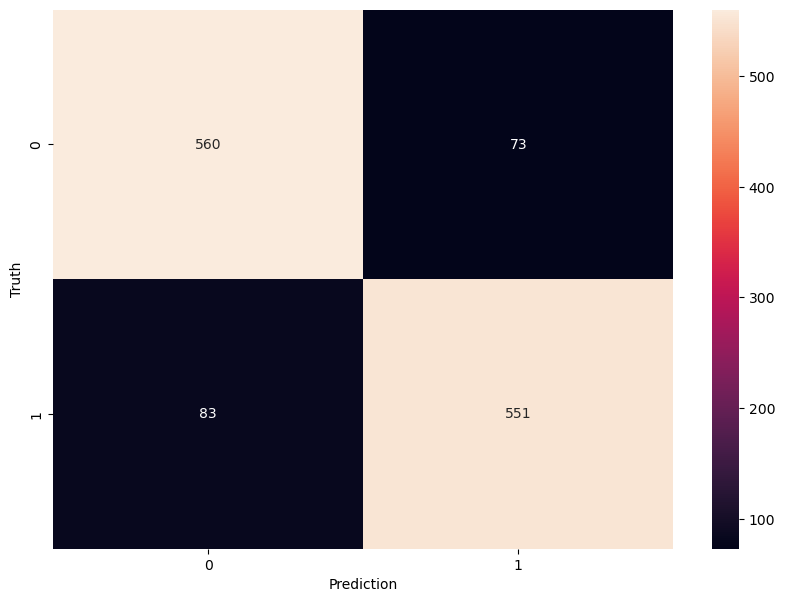

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')